In [ ]:
pip install pymorphy2

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpy as np
import pandas as pd
import re
from collections import Counter
import pymorphy2
from tqdm import tqdm_notebook
from sklearn.metrics import auc, f1_score, accuracy_score, roc_auc_score

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
pip install nltk

In [ ]:
!wget https://raw.githubusercontent.com/Astrowa/technopark/main/dz3/train.csv

--2020-11-10 11:03:18--  https://raw.githubusercontent.com/Astrowa/technopark/main/dz3/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19160453 (18M) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>]  18.27M  29.1MB/s    in 0.6s    

2020-11-10 11:03:19 (29.1 MB/s) - ‘train.csv.1’ saved [19160453/19160453]



In [ ]:
train_df = pd.read_csv("train.csv")

train_df.head()

,id,url,title,target
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",False
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,False
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,False
3,3,colorbox.spb.ru,Не Беси Меня Картинки,False
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,False


In [ ]:
!wget https://raw.githubusercontent.com/Astrowa/technopark/main/dz3/test.csv

--2020-11-10 11:03:19--  https://raw.githubusercontent.com/Astrowa/technopark/main/dz3/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22523993 (21M) [text/plain]
Saving to: ‘test.csv.1’

test.csv.1          100%[===================>]  21.48M  39.4MB/s    in 0.5s    

2020-11-10 11:03:20 (39.4 MB/s) - ‘test.csv.1’ saved [22523993/22523993]



In [ ]:
test_df = pd.read_csv("test.csv")

test_df.head()

,id,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67


In [ ]:
train_df["target"].value_counts()

False    118594
True      16715
Name: target, dtype: int64

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
X_train = train_df["title"].values
X_test = test_df["title"].values
y_train = train_df["target"].astype(int).values

## Simple baseline

In [ ]:
y_pred = [int("порно" in text) for text in X_train]

In [ ]:
f1_score(y_train, y_pred)

0.31242758551206484

### Submit

In [ ]:
test_df["target"] = [("порно" in text) for text in X_test]

test_df[["id", "target"]].to_csv("simple_baseline.csv", index=False)

!cat simple_baseline.csv | head

id,target
135309,False
135310,False
135311,False
135312,False
135313,False
135314,False
135315,False
135316,False
135317,False


### Не все так однозначно
## не порно:


*   Болезни опорно-двигательной системы и импотенция: взаимосвязь
*   Транссексуальные рыбы - National Geographic Россия: красота мира в каждом кадре
*   Групповая обзорная экскурсия по Афинам - цена €50
*   Больного раком Задорнова затравили в соцсетях.
*   Гомосексуалисты на «Первом канале»? Эрнст и Галкин – скрытая гей-пара российского шоу-бизнеса | Заметки о стиле, моде и жизни


## порно:

*   Отборная домашка
*   Сюзанна - карьера горничной / Susanna cameriera perversa (с русским переводом) 1995 г., DVDRip



### ML baseline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

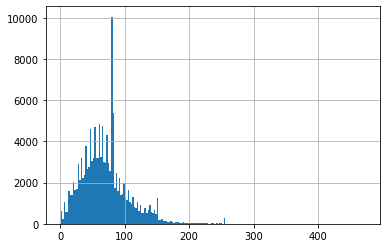

In [ ]:
train_df.title.str.len().hist(bins=200)

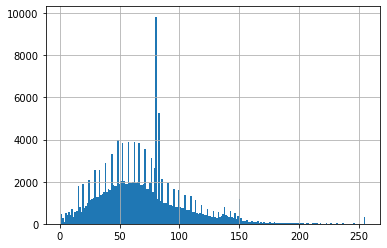

In [ ]:
test_df.title.str.len().hist(bins=200)

In [ ]:
corpus = train_df.title.values

In [ ]:
TOKEN_PATTERN = ("(?u)\\b\\w\\w+\\b") #"[а-я-a-z]"

In [ ]:
def tokenize(text):
    return re.findall(TOKEN_PATTERN, text.lower())

docs = [tokenize(text) for text in corpus]

In [ ]:
occurence = Counter()

for doc in docs:
    for token in doc:
        occurence[token] += 1

In [ ]:
occurence.most_common(20)

[('на', 22881),
 ('ru', 14162),
 ('онлайн', 11968),
 ('для', 10174),
 ('по', 8444),
 ('бесплатно', 8243),
 ('скачать', 7751),
 ('mail', 6807),
 ('фото', 6378),
 ('купить', 6315),
 ('страница', 5847),
 ('смотреть', 5542),
 ('от', 5357),
 ('поиск', 5310),
 ('порно', 5210),
 ('видео', 5138),
 ('2019', 4087),
 ('porn', 3757),
 ('из', 3709),
 ('интернет', 3429)]

In [ ]:
stopword_set = set(nltk.corpus.stopwords.words() + ['-', 'тыс'])

In [ ]:
sorted_tokens = sorted(occurence.keys())

In [ ]:
lemmatizer = pymorphy2.MorphAnalyzer()

In [ ]:
lemmatizer_cache = {}

def lemmatize(token):
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

lemmatized_docs = [[lemmatize(token) for token in text] for text in tqdm_notebook(docs)]

cleared_docs = [[token for token in text if token not in stopword_set] for text in lemmatized_docs]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
cleared_docs[108]

['ջահեր', 'tinko', '47209', '1h', '930', 'դրամ', 'բրայթ', 'հաուս']

In [ ]:
train_df["title"][100:125]

100    Фото со мной - 21 фото. Фотографии Олеся Швецова.
101    Строительство коттеджей из пенобетона под ключ...
102    Военная тематика » Страница 18 » Скачать книги...
103    Магазин электронных компонентов "ЭЛЕКТРОНЩИК" ...
104      Сушка дерева в вакуумной камере - Guns.ru Talks
105    Picanto. Срок поставки КИА Пиканто. Субкомпакт...
106    Почтовый индекс Улицы Льва Толстого Санкт-Пете...
107    Комплект муравьиной фермы Smart "Горный мох" ✅...
108    Ջահեր-TINKO 47209/1H - 6.930 դրամ - «Բրայթ Հաուս»
109    Презентація - Сутність маркетингу та його визн...
110    Марсель Муратов - Казань, Татарстан, Россия, 3...
111                           Charlie Red Anal – DaftSex
112                                     Администрация ДК
113                                           город Холм
114    В Челябинской области появится еще три виртуал...
115    анжелика агурбаш мне любви твоей мало музыка в...
116         Необычные рецепты | Вкусные Идеи Каждый День
117    Девчат, с радостью бы по

In [ ]:
cooccurence = Counter()

for doc in docs:
    for i in range(len(doc) - 1):
        cooccurence[(doc[i], doc[i + 1])] += 1

In [ ]:
cooccurence.most_common(10)

[(('mail', 'ru'), 6701),
 (('смотреть', 'онлайн'), 3818),
 (('поиск', 'mail'), 3502),
 (('результатов', 'поиск'), 2622),
 (('скачать', 'бесплатно'), 2012),
 (('онлайн', 'бесплатно'), 1967),
 (('читать', 'онлайн'), 1808),
 (('тыс', 'результатов'), 1611),
 (('порно', 'видео'), 1525),
 (('интернет', 'магазине'), 1419)]

In [ ]:
occurence.most_common(10)

[('на', 22881),
 ('ru', 14162),
 ('онлайн', 11968),
 ('для', 10174),
 ('по', 8444),
 ('бесплатно', 8243),
 ('скачать', 7751),
 ('mail', 6807),
 ('фото', 6378),
 ('купить', 6315)]

In [ ]:
N = sum(occurence.values())

N

1248292

In [ ]:
pmi = Counter()
min_cooccur = 5

for pair in cooccurence:
    if cooccurence[pair] >= min_cooccur:
        pmi[pair] = np.log(cooccurence[pair] * N / occurence[pair[0]] / occurence[pair[1]])

In [ ]:
pmi.most_common(10)

[(('nowy', 'styl'), 12.427848862468652),
 (('sputnjik', 'srbija'), 12.427848862468652),
 (('xarid', 'qilish'), 12.427848862468652),
 (('зарегистрировано', 'минюсте'), 12.427848862468652),
 (('xander', 'corvus'), 12.427848862468652),
 (('kagney', 'linn'), 12.427848862468652),
 (('linn', 'karter'), 12.427848862468652),
 (('játssz', 'ingyen'), 12.427848862468652),
 (('мобільна', 'версія'), 12.427848862468652),
 (('sklep', 'internetowy'), 12.427848862468652)]

In [ ]:
cleared_docs[910]

['руководство', 'издание', 'четвёртый', 'дополнить', 'переработать']

In [ ]:
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x, lowercase=False,
    norm='l2'
)

In [ ]:
test = test_df.title.values
docs_test = [tokenize(text) for text in test]

occurence_test = Counter()

for doc in docs_test:
    for token in doc:
        occurence_test[token] += 1

sorted_tokens_test = sorted(occurence_test.keys())

lemmatizer_cache_test = {}

def lemmatize(token):
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache_test:
            lemmatizer_cache_test[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache_test[token]
    return token

lemmatized_docs_test = [[lemmatize(token) for token in text] for text in tqdm_notebook(docs_test)]

cleared_docs_test = [[token for token in text if token not in stopword_set] for text in lemmatized_docs_test]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
model = MultinomialNB()

In [ ]:
X_train_vectorized = vectorizer.fit_transform(cleared_docs)

In [ ]:
X_train_vectorized

<135309x144382 sparse matrix of type '<class 'numpy.float64'>'
	with 1074281 stored elements in Compressed Sparse Row format>

In [ ]:
feature_names = np.array(vectorizer.get_feature_names())

In [ ]:
id_ = 42

print(X_train[id_])

x_vector = X_train_vectorized.getrow(id_).toarray()[0]

[feature for feature in feature_names[x_vector > 0]]

Презентация на тему "Приближенное значение. Абсолютная и относительная погрешнос


['абсолютный',
 'значение',
 'относительный',
 'погрешнос',
 'презентация',
 'приблизить',
 'тема']

In [ ]:
%%time

model.fit(
    X_train_vectorized,
    y_train
)

y_pred = model.predict(
    X_train_vectorized
)

CPU times: user 59.7 ms, sys: 993 µs, total: 60.7 ms
Wall time: 61.4 ms


In [ ]:
f1_score(y_train, y_pred)

0.9342175232256248

In [ ]:
import IPython
print(IPython.sys_info())

{'commit_hash': 'b467d487e',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/usr/local/lib/python3.6/dist-packages/IPython',
 'ipython_version': '5.5.0',
 'os_name': 'posix',
 'platform': 'Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic',
 'sys_executable': '/usr/bin/python3',
 'sys_platform': 'linux',
 'sys_version': '3.6.9 (default, Oct  8 2020, 12:12:24) \n[GCC 8.4.0]'}


### Submit

In [ ]:
X_test_vectorized = vectorizer.transform(cleared_docs_test)

test_df["target"] = model.predict(X_test_vectorized).astype(bool)

test_df[["id", "target"]].to_csv("ml_baseline.csv", index=False)

%cat ml_baseline.csv | head

id,target
135309,False
135310,False
135311,False
135312,True
135313,False
135314,False
135315,False
135316,False
135317,False


In [ ]:
X_test_vectorized.shape

(165378, 144382)

In [ ]:
def print_metrics(y_test, ans):
    print(("Accuracy ~"), np.round(accuracy_score(y_test, ans), 4))
    print(("F1_score ~"), np.round(f1_score(y_test, ans, average="macro"), 4))

## BEST

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
%%time

model = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, verbose=1)
model.fit(X_train_vectorized, y_train.ravel())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.2min


CPU times: user 22min 32s, sys: 2.3 s, total: 22min 35s
Wall time: 11min 33s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.6min finished


In [ ]:
model

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=1,
                     warm_start=False)

In [ ]:
model_ans = model.predict(X_train_vectorized)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   23.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   50.0s finished


In [ ]:
print_metrics(y_train, model_ans)

Accuracy ~ 0.9988
F1_score ~ 0.9973


In [ ]:
X_test_vectorized = vectorizer.transform(cleared_docs_test)

test_df["target"] = model.predict(X_test_vectorized).astype(bool)

test_df[["id", "target"]].to_csv("ETC100_vector.csv", index=False)

%cat ETC100_vector.csv | head

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   30.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.1min finished


id,target
135309,False
135310,False
135311,False
135312,True
135313,False
135314,False
135315,False
135316,False
135317,False


### Попытки

In [ ]:
%%time

RF = RandomForestClassifier(n_estimators=2900, min_samples_leaf=1, min_samples_split=6, verbose=1, n_jobs=-1)
RF.fit(X_train_vectorized, y_train.ravel())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 51.0min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 73.0min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 99.5min


CPU times: user 3h 51min 19s, sys: 19.4 s, total: 3h 51min 39s
Wall time: 1h 58min 1s


[Parallel(n_jobs=-1)]: Done 2900 out of 2900 | elapsed: 118.0min finished


In [ ]:
RF_ans = RF.predict(X_train_vectorized)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   58.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  9.0min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed: 12.2min
[Parallel(n_jobs=2)]: Done 2900 out of 2900 | elapsed: 14.5min finished


In [ ]:
print_metrics(y_train, RF_ans)

Accuracy ~ 0.998
F1_score ~ 0.9953


In [ ]:
RF

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=29, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
X_test_vectorized = vectorizer.transform(cleared_docs_test)

test_df["target"] = RF.predict(X_test_vectorized).astype(bool)

test_df[["id", "target"]].to_csv("RF_290_vector_t.csv", index=False)

%cat RF_290_vector_t.csv | head

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  8.0min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed: 11.5min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed: 15.7min
[Parallel(n_jobs=2)]: Done 2900 out of 2900 | elapsed: 18.6min finished


id,target
135309,False
135310,False
135311,False
135312,True
135313,False
135314,False
135315,False
135316,False
135317,False


In [ ]:
%%time

RF10 = RandomForestClassifier(n_estimators=5000, min_samples_leaf=1, min_samples_split=2, verbose=1, n_jobs=-1)
RF10.fit(X_train_vectorized, y_train.ravel())

NameError: ignored

In [ ]:
RF10_ans = RF10.predict(X_train_vectorized)

In [ ]:
print_metrics(y_train, RF10_ans)

In [ ]:
X_test_vectorized = vectorizer.transform(cleared_docs_test)

test_df["target"] = RF10.predict(X_test_vectorized).astype(bool)

test_df[["id", "target"]].to_csv("RF_10000_vector_t.csv", index=False)

%cat RF_10000_vector_t.csv | head

In [ ]:
clf = RandomForestClassifier()

In [ ]:
parametrs = { 'n_estimators': range (25, 26, 1),
              'min_samples_leaf': range (1,6),
              'min_samples_split': range (2,8,2) }

In [ ]:
grid = GridSearchCV(clf, parametrs, cv=5, n_jobs=-1)

In [ ]:
%%time

grid.fit(X_train_vectorized, y_train.ravel())

CPU times: user 1min 35s, sys: 118 ms, total: 1min 35s
Wall time: 6h 14min 38s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
grid.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 25}

бэггинг

In [ ]:
n_estimators = 30
answer = np.zeros((n_estimators, X_test.shape[0]), dtype=int)

In [ ]:
y_train.shape

(135309,)

In [ ]:
for i in tqdm_notebook(range(n_estimators)):
    DT = DecisionTreeClassifier()
    index = np.random.choice(np.arange(X_train_vectorized.shape[0]), X_train_vectorized.shape[0])
    DT.fit(X_train_vectorized[index], y_train[index])
    answer[i] = DT.predict(X_test_vectorized)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [ ]:
bagging_dt_answer = [np.bincount(answer[:, i]).argmax() for i in range(answer.shape[1])]

In [ ]:
bagging_dt_answer[3]

1

In [ ]:
for i in range(len(bagging_dt_answer)):
    if bagging_dt_answer[i] == 0:
        bagging_dt_answer[i] = False
    else:
        bagging_dt_answer[i] = True

In [ ]:
test_df["target"] = bagging_dt_answer


test_df[["id", "target"]].to_csv("bagging.csv", index=False)

%cat bagging.csv | head

id,target
135309,False
135310,False
135311,False
135312,True
135313,False
135314,False
135315,False
135316,False
135317,False


In [ ]:
model2 = ExtraTreesClassifier(n_estimators=200, n_jobs=-1, verbose=1)
model2.fit(X_train_vectorized, y_train.ravel())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 13.9min finished


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=1,
                     warm_start=False)

In [ ]:
model2_ans = model2.predict(X_train_vectorized)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   21.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:  1.5min finished


In [ ]:
print_metrics(y_train, model2_ans)

Accuracy ~ 0.9982
F1_score ~ 0.9958


In [ ]:
X_test_vectorized = vectorizer.transform(cleared_docs_test)

test_df["target"] = model2.predict(X_test_vectorized).astype(bool)

test_df[["id", "target"]].to_csv("ETC200_vector.csv", index=False)

%cat ETC200_vector.csv | head

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   27.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:  2.0min finished


id,target
135309,False
135310,False
135311,False
135312,True
135313,False
135314,False
135315,False
135316,False
135317,False


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=30, max_depth=50, verbose=1)

In [ ]:
%%time

gbc.fit(X_train_vectorized, y_train.ravel())

      Iter       Train Loss   Remaining Time 
         1           0.5909            6.86m
         2           0.5114            6.71m
         3           0.4549            6.49m
         4           0.4106            6.27m
         5           0.3745            6.04m
         6           0.3438            5.81m
         7           0.3176            5.63m
         8           0.2959            5.40m
         9           0.2762            5.20m
        10           0.2589            5.02m
        20           0.1604            2.68m
        30           0.1137            0.00s
CPU times: user 8min 38s, sys: 104 ms, total: 8min 38s
Wall time: 8min 39s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=50,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=30,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [ ]:
gbc_ans = gbc.predict(X_train_vectorized)

In [ ]:
print_metrics(y_train, gbc_ans)

Accuracy ~ 0.9886
F1_score ~ 0.9725


n_estimators=100:

Accuracy ~ 0.9644    
F1_score ~ 0.9059

n_estimators=100:

Accuracy ~ 0.9826
F1_score ~ 0.9572

n_estimators=30, max_depth = None:

Accuracy ~ 0.9988
F1_score ~ 0.9973

In [ ]:
X_test_vectorized = vectorizer.transform(X_test)

test_df["target"] = gbc.predict(X_test_vectorized).astype(bool)

test_df[["id", "target"]].to_csv("gbc_vector.csv", index=False)

%cat gbc_vector.csv | head

id,target
135309,False
135310,False
135311,False
135312,True
135313,False
135314,False
135315,False
135316,False
135317,False


In [ ]:
pip install xgboost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
pip install hyperopt

In [ ]:
%%time

import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
 
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
 
X = X_train_vectorized
y = y_train.ravel()
 
 
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, X, y, cv=3).mean()
    print(current_score, params)
    return -current_score
 
 
simple_space_xgb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
            'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
}
 
best = fmin(fn=hyperopt_xgb_score, space=simple_space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.9727069152827972
{'eta': 0.05, 'max_depth': 1, 'n_estimators': 713}
0.9835487661574618
{'eta': 0.35000000000000003, 'max_depth': 5, 'n_estimators': 580}
0.9848716641169472
{'eta': 0.07500000000000001, 'max_depth': 5, 'n_estimators': 806}
0.9732020782061799
{'eta': 0.05, 'max_depth': 2, 'n_estimators': 337}
0.9839478526927256
{'eta': 0.05, 'max_depth': 10, 'n_estimators': 310}
0.9789962234588977
{'eta': 0.5, 'max_depth': 4, 'n_estimators': 327}
0.9838296048304253
{'eta': 0.17500000000000002, 'max_depth': 10, 'n_estimators': 302}
0.9802747784700204
{'eta': 0.275, 'max_depth': 10, 'n_estimators': 153}
0.9801195781507513
{'eta': 0.1, 'max_depth': 11, 'n_estimators': 137}
0.9798830824261505
{'eta': 0.2, 'max_depth': 11, 'n_estimators': 132}
100%|██████████| 10/10 [1:08:32<00:00, 411.21s/it, best loss: -0.9848716641169472]
best:
{'eta': 0.07500000000000001, 'max_depth': 4, 'n_estimators': 706}
CPU times: user 1h 8min 23s, sys: 2.82 s, total: 1h 8min 26s
Wall time: 1h 8min 32s


In [ ]:
xgb = XGBClassifier(eta = 0.07500000000000001, max_depth = 5, n_estimators = 806)

In [ ]:
xgb.fit(X_train_vectorized, y_train.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.07500000000000001,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=806, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_ans = xgb.predict(X_train_vectorized)

In [ ]:
print_metrics(y_train, xgb_ans)#получился скор 0.92. ради интереса можно будет попробовать  max_depth = 5, n_estimators = 806

Accuracy ~ 0.9879
F1_score ~ 0.9709


In [ ]:
X_test_vectorized = vectorizer.transform(cleared_docs_test)

test_df["target"] = xgb.predict(X_test_vectorized).astype(bool)

test_df[["id", "target"]].to_csv("xgb_vector_t.csv", index=False)

%cat xgb_vector_t.csv | head

id,target
135309,False
135310,False
135311,False
135312,True
135313,False
135314,False
135315,False
135316,False
135317,False
